<a href="https://colab.research.google.com/github/kathmandu777/Img-and-Video-check/blob/main/GenTwo_imgcheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenTwoの投稿画像検証
- GenTwoにおいて、投稿された画像が不適切かどうかを判断します。

<br>  
***

### 設計
1. 投稿画像の受け取り
2. 画像認識
  - YOLO（性能と速度によっては変更）
  - 現在はSSDを使用
3. 認識物がNGリストに載っていればリジェクト
  - 何がリジェクトされたか、ユーザーが分かるようにバウンディングボックスの描画
4. [ ユーザーが不快画像として報告した画像から、モデルを再構築（転移学習を利用）]

### 検出オブジェクトNGリスト
- undefined

<br>  
***

## 知識
#### 物体検出について
- 物体検出(object detection)=クラス(カテゴリー)と一緒に物体の位置を予測すること
- 矩形（バウンディングボックス）= 物体の位置情報を示した図形


#### 物体検出のアルゴリズム
- Faster R-CNN : CNNを利用した物体検出の先駆けであるR-CNNを高速化したモデル。従来のR-CNNは候補領域の抽出・特徴量の計算・物体クラス分類をそれぞれ別個の処理として行っていたため高速な物体検出の処理が困難であった。このモデルではこれらの処理を1つの畳み込みCNNにまとめることで高速な物体検出の処理を実現している。

- Mask R-CNN : Faster R-CNNの改良モデル。通常の物体検出のように物体の位置を矩形領域ではなく物体の輪郭に沿った形で推定するセグメンテーションも同時に行うマルチタスク学習に分類される。輪郭に沿った形で物体を検出できるため人間の手や足の関節の位置を推定して骨格に相当する情報を抽出する姿勢推定への応用が可能。

- YOLO : You Only Look Onceの略で「見るのは一度だけ」という意味。従来の手法では候補領域の抽出の際に入力画像をスキャンしていたため入力画像を何度も見る必要があった。YOLOは入力画像をグリッドに分割してからそれぞれのグリッドに物体がふくまれている確率を推定する回帰問題として物体検出を定式化することにより、入力画像を1回だけ見れば物体検出ができるようになっている。これにより、Faster R-CNNと同様に1つの畳み込みCNNでモデルを構成することができるようになり高速な処理が可能となった。

- SSD : Single Shot MultiBox Detector の略。2016年に提案されたモデル。画像に8732個のデフォルトボックスを敷き詰め、デフォルトボックスごとに位置推定とクラス分類を実行する。ボックスと物体の位置の差分を計算する方法により、ネットワーク処理がシンプルになり大幅に速度が向上。リアルタイムでの物体検出を実現している。


### 参考文献
- [markdown記法](https://qiita.com/tbpgr/items/989c6badefff69377da7#%E5%BC%95%E7%94%A8)
- [TensorHubについて](https://kamujun.hatenablog.com/entry/2018/08/10/183201)
- [colabでのTensorFlow Hub使用方法](https://qiita.com/code0327/items/3b23fd5002b373dc8ae8)
- [TensorHubの物体検出学習済みモデル](https://tfhub.dev/s?module-type=image-object-detection)
- [物体検出について](https://qiita.com/mshinoda88/items/9770ee671ea27f2c81a9)
- [機械学習における正解率の各指標まとめ](https://qiita.com/cv_carnavi/items/08e11426e2fac8433fed)

In [22]:
# 環境変数を追加
# 検出器のモジュールを格納するフォルダの設定
import os
os.environ['TFHUB_CACHE_DIR'] ='/content/tfhub'

# 環境変数の確認
!printenv TFHUB_CACHE_DIR

# TensorFlow2.xに切り替え
%tensorflow_version 2.x

/content/tfhub


In [23]:
# 検出器のロード
import tensorflow as tf
import tensorflow_hub as hub

print("loading model")

# tensorHubにある好きなモデルを指定

"""
wildspeed.jpgで実験

https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1 = 45.637sec 精度はまあ良い
https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1 = 0.262sec 余分なところも反応している
https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 = 71.238sec 精度は素晴らしい
https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1 = 6.89sec
"""
module_handle = "https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1"

#tensorflow製の時
detector = hub.load(module_handle)

#google製の時
# detector = hub.load(module_handle).signatures['default']

print("load end")

loading model
load end


In [24]:
# tensorflow COCO class_id -> class_name
!wget https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt

id_to_name_dic={}
with open("labels.txt",mode="r") as f:
  for line in f:
    i,name=line.split(":")
    id_to_name_dic[i]=str(name)

print(id_to_name_dic)

--2021-02-22 05:54:10--  https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2287 (2.2K) [text/plain]
Saving to: ‘labels.txt.2’

labels.txt.2        100%[===================>]   2.23K  --.-KB/s    in 0s      

2021-02-22 05:54:11 (41.5 MB/s) - ‘labels.txt.2’ saved [2287/2287]

{'0': ' unlabeled\n', '1': ' person\n', '2': ' bicycle\n', '3': ' car\n', '4': ' motorcycle\n', '5': ' airplane\n', '6': ' bus\n', '7': ' train\n', '8': ' truck\n', '9': ' boat\n', '10': ' traffic light\n', '11': ' fire hydrant\n', '12': ' street sign\n', '13': ' stop sign\n', '14': ' parking meter\n', '15': ' bench\n', '16': ' bird\n', '17': ' cat\n', '18': ' dog\n', '19': ' horse\n', '20': ' sheep\n', '21': ' cow\n',

In [25]:
# 検出結果を画像にオーバーレイ表示する関数定義
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe 

def showImage(img, r, min_score=0.1):
  fig = plt.figure(dpi=150,figsize=(4,4))
  ax = plt.gca()
  ax.tick_params(axis='both', which='both', left=False, 
                 labelleft=False, bottom=False, labelbottom=False)
  ax.imshow(img)

  decode = np.frompyfunc( lambda p : p.decode("ascii"), 1, 1)

  boxes =       r['detection_boxes']
  scores =      r['detection_scores']
  class_names = r['detection_classes'] # google=detection_class_entities, tensorflow=

  boxes=boxes[0] # tensorflow
  class_names=class_names[0] # tensorflow
  scores=scores[0]

  n = np.count_nonzero(scores >= min_score)

  # class_names に対応した 色の準備
  class_set = np.unique(class_names[:n])
  colors = dict()
  cmap = plt.get_cmap('tab10')
  for i, v in enumerate(class_set):
    colors[v] =cmap(i)

  # 矩形を描画 スコアが低いものから描画
  img_w = img.shape[1]
  img_h = img.shape[0]
  for i in reversed(range(n)):
    class_name=id_to_name_dic[str(int(class_names[i]))]
    score=float(scores[i])

    text = f'{class_name} {100*score:.0f}%'
    color = colors[class_names[i]]
    y1, x1, y2, x2 = tuple(boxes[i])
    y1, y2 = y1*img_h, y2*img_h
    x1, x2 = x1*img_w, x2*img_w

    # 枠
    r = plt.Rectangle(xy=(x1, y1), width=(x2-x1), height=(y2-y1),
                      fill=False, edgecolor=color, joinstyle='round', 
                      clip_on=False, zorder=8+(n-i) )
    ax.add_patch( r )

    # タグ：テキスト
    t = ax.text(x1+img_w/200, y1-img_h/300, text, va='bottom', fontsize=6, color=color,zorder=8+(n-i))
    t.set_path_effects([pe.Stroke(linewidth=1.5,foreground='white'), pe.Normal()])
    fig.canvas.draw()
    r = fig.canvas.get_renderer()
    coords = ax.transData.inverted().transform(t.get_window_extent(renderer=r))
    tag_w = abs(coords[0,0]-coords[1,0])+img_w/100
    tag_h = abs(coords[0,1]-coords[1,1])+img_h/120

    # タグ：背景
    r = plt.Rectangle(xy=(x1, y1-tag_h), width=tag_w, height=tag_h,
                      edgecolor=color, facecolor=color,
                      joinstyle='round', clip_on=False, zorder=8+(n-i))
    ax.add_patch(r)


In [26]:
# 物体検出を実行する関数定義
import time
import numpy as np
import PIL.Image as Image

def run_detector(detector, path):

  # 画像を読み込んで detector に入力できる形式に変換
  img = Image.open(path) # Pillow(PIL)
  if img.mode == 'RGBA' :
    img = img.convert('RGB')
  
  converted_img = img.copy()
  converted_img = converted_img.resize((227,227),Image.LANCZOS) # 入力サイズに縮小
  converted_img = np.array(converted_img, dtype=np.float32)     # np.arrayに変換
  # converted_img = converted_img / 255. # 0.0 ～ 1.0 に正規化 # tensorflow製のときは行わない
  converted_img = converted_img.reshape([1,227,227,3])
  converted_img = tf.constant(converted_img)
  
  # tensorflow only
  converted_img = tf.cast(converted_img, dtype=tf.uint8)

  t1 = time.time()
  result = detector(converted_img) # 一般物体検出（本体）
  t2 = time.time()
  print()
  print(f'検出時間 : {t2-t1:.3f} 秒' )
  # 結果をテキスト出力するための準備
  r = {key:value.numpy() for key,value in result.items()}
  boxes =       r['detection_boxes']
  scores =      r['detection_scores']
  decode = np.frompyfunc( lambda p : p.decode('ascii'), 1, 1)
  # class_names = decode( r['detection_class_entities'] ) # google
  class_names = r['detection_classes']  # tensorflow

  boxes=boxes[0] # tensorflow
  class_names=class_names[0] # tensorflow
  scores=scores[0]

  # スコアが 0.25 以上の結果（n件）についてテキスト出力  閾値はデプロイ時に最適化する
  print(f'検出オブジェクト' )
  n = np.count_nonzero(scores >= 0.25 )
  for i in range(n):
    y1, x1, y2, x2 = tuple(boxes[i])
    x1, x2 = int(x1*img.width), int(x2*img.width)
    y1, y2 = int(y1*img.height),int(y2*img.height)
    #t = f'{class_names[i]:10} {100*scores[i]:3.0f}%  ' # google
    class_name=id_to_name_dic[str(int(class_names[i]))]
    score=float(scores[i])
    t = f'{class_name:10} {100*score:3.0f}%  ' # tensorflow
    t += f'({x1:>4},{y1:>4}) - ({x2:>4},{y2:>4})'
    print(t)

  showImage(np.array(img), r, min_score=0.25) # 検出結果を画像にオーバーレイ(上で定義した関数)


物体検出したい画像を選択してください(複数選択可)

検出時間 : 45.637 秒
検出オブジェクト
 person
    99%  ( 785,   9) - (1051, 449)
 person
    97%  ( 678,  42) - ( 861, 450)
 person
    97%  ( 150,  77) - ( 355, 323)
 car
       84%  (   0, 227) - ( 408, 450)
 car
       66%  ( 487, 260) - ( 656, 374)
 person
    61%  ( 382, 208) - ( 441, 274)
 person
    59%  ( 456, 215) - ( 506, 307)
 cell phone
  56%  ( 719,  46) - ( 769,  98)
 car
       48%  (   0, 253) - ( 115, 420)
 person
    48%  ( 300, 124) - ( 389, 332)
 skis
      44%  ( 603,  84) - ( 731, 444)
 person
    30%  (1022, 157) - (1071, 410)
 surfboard
  29%  ( 605,  87) - ( 720, 434)
 bicycle
   27%  (   1, 384) - ( 126, 451)
 person
    27%  ( 380, 204) - ( 450, 325)
 person
    26%  ( 611,  79) - ( 760, 448)


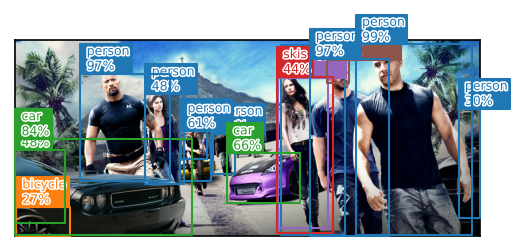

In [27]:
# 物体検出
from google.colab import files

print("\n物体検出したい画像を選択してください(複数選択可)")
# uploaded = files.upload() # 分類したい画像を選択
  
# for fn in uploaded.keys():
#   run_detector(detector, fn)

run_detector(detector,"./wildspeed.jpg")
